In [1]:
import pandas as pd
import pandas_datareader.data 
import numpy as np 
from pandas import DataFrame,Series
from numpy.random import  randn
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline


from collections import Counter
from datetime import datetime as dt
import csv
import math

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


Data from Tokyo Electric power co to show how much people consumes electricity. As an input data, I downloaded the weather data from Japan Meteorlogical Agency. It creates one more extra steps to process the data as two separated data is convereted, however it is worth trying.
 
Main Goal here is creating MODEL to forecast future electricity energy consumption   
  
As first step, I need to ensure that 'DATE' is datetime. When I convert the data, i will make sure both data has same  
type of datetime index.  Confirm date( type, # of index & columns)   -> Amend the name of columns to analyze easily -> change to datetime if necessary  

# Loading & Confirming & Cleaning Data 

In [6]:
res=pd.read_csv('restaurant.csv')
item=pd.read_csv('item.csv')

In [61]:
item.describe()

,id,restaurant_id,chill_rating,has_gst
count,1221.000000,1221.000000,1221.000000,1221.0
mean,611.000000,46.311220,1.520885,1.0
std,352.616647,30.836424,1.123781,0.0
min,1.000000,1.000000,0.000000,1.0
25%,306.000000,18.000000,1.000000,1.0
50%,611.000000,46.000000,2.000000,1.0
75%,916.000000,75.000000,3.000000,1.0
max,1221.000000,122.000000,3.000000,1.0


In [562]:
df=pd.read_excel('Electricity_2019.xlsx',sheet_name='Sheet1',index_col = 0,parse_dates=True,skiprows=2)

In [563]:
w_df=pd.read_excel('weather _ Tokyo 2019.xlsx',index_col=0,parse_date=True)

In [569]:
df.head()

,TIME,kW:10000
DATE,,
2019-01-01,00:00:00,3017
2019-01-01,01:00:00,2849
2019-01-01,02:00:00,2730
2019-01-01,03:00:00,2636
2019-01-01,04:00:00,2579


In [570]:
df['DATE']=df.index

In [571]:
list=[]
for i in range(len(df['DATE'])):
    x=(str(df['DATE'][i])[:-8])+(str(df['TIME'][i]))
    list.append(x)

In [572]:
df.index=list

In [573]:
df=df.rename(columns={'kW:10000':'KW'})
# change the column name in order to understand easily 

In [574]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 2019-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TIME    8760 non-null   object        
 1   KW      8760 non-null   int64         
 2   DATE    8760 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 273.8+ KB


In [575]:
df.index= pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
df['MONTH']=df.index.month
df.TIME=df.index.hour
df['WEEK']=df.index.week
df['Mon~Sun']=df.index.day_name()

In [576]:
df=df.drop('DATE',axis=1)

In [577]:
df.head()

,TIME,KW,MONTH,WEEK,Mon~Sun
2019-01-01 00:00:00,0,3017,1,1,Tuesday
2019-01-01 01:00:00,1,2849,1,1,Tuesday
2019-01-01 02:00:00,2,2730,1,1,Tuesday
2019-01-01 03:00:00,3,2636,1,1,Tuesday
2019-01-01 04:00:00,4,2579,1,1,Tuesday


In [578]:
w_df.head()

,Weather (06:00～18:00),Weather (18:00～06:00),Ave Temp,Max Temp,Time for Max Temp,Min Temp,Time for Min Temp,Rain Amt(mm),Hours of Daylight (Hrs),Snow Amt(cm),Mean Wind Speed(m/s),Mean Steam Pressure(hPa),Mean Cloudiness(1~10)
Date,,,,,,,,,,,,,
2019-01-01,sunny,clear,5.3,10.7,2019-01-01 13:33:00,0.9,2019-01-01 06:36:00,0.0,8.9,0,2.3,4.7,0.5
2019-01-02,clear,clear,6.2,10.9,2019-01-02 13:24:00,2.2,2019-01-02 02:22:00,0.0,8.7,0,2.9,4.3,0.3
2019-01-03,clear,clear,4.9,10.9,2019-01-03 13:03:00,-0.3,2019-01-03 06:52:00,0.0,8.9,0,3.1,4.1,0.0
2019-01-04,clear,sunny,5.1,9.8,2019-01-04 13:16:00,0.2,2019-01-04 06:56:00,0.0,8.9,0,2.0,5.1,1.5
2019-01-05,clear,sunny/cloudy,7.4,14.0,2019-01-05 14:30:00,0.9,2019-01-05 04:10:00,0.0,8.9,0,2.1,5.2,0.5


In [579]:
w_df.columns=['W _day', 'W_night', 'Ave Temp',
       'Max Temp', 'Time for Max Temp', 'Min Temp', 'Time for Min Temp',
       'Rain Amt_mm', 'Daylight _Hrs', 'Snow Amt_cm',
       'Mean Wind Speed', 'Level_Humidity_hPa',
       'M_Cloudiness_level']
# Change the column names in order to understand easily

In [580]:
w_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   W _day              365 non-null    object        
 1   W_night             365 non-null    object        
 2   Ave Temp            365 non-null    float64       
 3   Max Temp            365 non-null    float64       
 4   Time for Max Temp   365 non-null    datetime64[ns]
 5   Min Temp            365 non-null    float64       
 6   Time for Min Temp   365 non-null    datetime64[ns]
 7   Rain Amt_mm         365 non-null    float64       
 8   Daylight _Hrs       365 non-null    float64       
 9   Snow Amt_cm         365 non-null    int64         
 10  Mean Wind Speed     365 non-null    float64       
 11  Level_Humidity_hPa  365 non-null    float64       
 12  M_Cloudiness_level  365 non-null    float64       
dtypes: datetime64[ns](2), float64(8

In [581]:
df.describe()

,TIME,KW,MONTH,WEEK
count,8760.000000,8760.000000,8760.000000,8760.000000
mean,11.500000,3256.967352,6.526027,26.430137
std,6.922582,640.885239,3.448048,15.047769
min,0.000000,1984.000000,1.000000,1.000000
25%,5.750000,2751.000000,4.000000,13.000000
50%,11.500000,3211.500000,7.000000,26.000000
75%,17.250000,3671.250000,10.000000,39.000000
max,23.000000,5543.000000,12.000000,52.000000


In [582]:
w_df.describe() # Daylight_Hrs ???

,Ave Temp,Max Temp,Min Temp,Rain Amt_mm,Daylight _Hrs,Snow Amt_cm,Mean Wind Speed,Level_Humidity_hPa,M_Cloudiness_level
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.0,365.000000,365.000000,365.000000
mean,16.494795,20.943014,12.824932,5.134247,5.230137,0.0,2.845479,15.270137,6.773973
std,7.818645,7.983220,8.097331,17.463378,4.132433,0.0,0.861740,9.152047,3.222816
min,0.800000,3.500000,-1.200000,0.000000,0.000000,0.0,1.400000,3.200000,0.000000
25%,9.000000,14.000000,5.400000,0.000000,0.500000,0.0,2.200000,7.000000,4.300000
50%,16.900000,21.500000,13.300000,0.000000,5.600000,0.0,2.700000,13.800000,7.500000
75%,22.900000,27.700000,19.700000,2.500000,8.900000,0.0,3.200000,22.200000,10.000000
max,30.500000,36.200000,28.000000,209.500000,13.600000,0.0,7.100000,34.500000,10.000000


# Analyze and Visualize Data 

Text(0, 0.5, 'Total Electiricy consumed:2019')

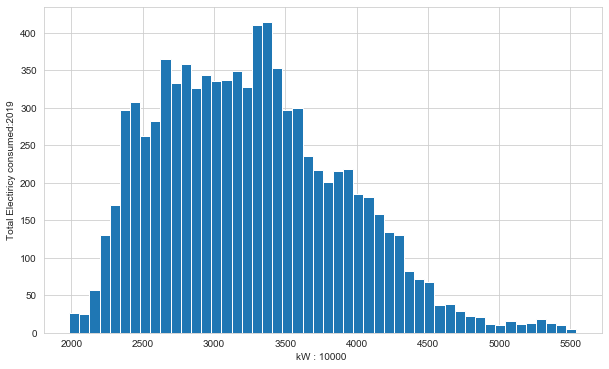

In [583]:
plt.figure(figsize = (10,6))
plt.hist(df.KW,bins=50,rwidth = 1.2)

plt.xlabel('kW : 10000 ')
plt.ylabel('Total Electiricy consumed:2019')  

# this is a data looks like i want to presume 

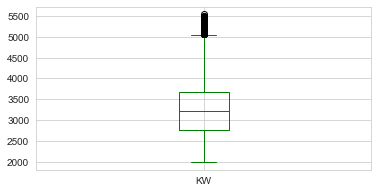

In [587]:
df['KW'].plot.box(figsize=(6,3),color='g')

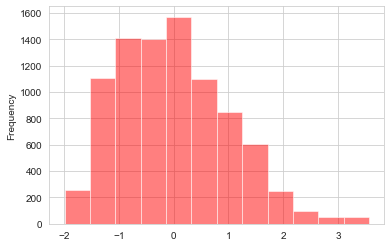

In [608]:
m=df['KW'].mean()
s=df['KW'].std()
m_KW2=df['KW']-m
m_KW3=m_KW2/m_KW2.std()
m_KW3.plot.hist(bins=12,alpha=0.5,figsize=(6,4),color='r')
Image(url='http://upload.wikimedia.org/wikipedia/commons/thumb/2/25/The_Normal_Distribution.svg/725px-The_Normal_Distribution.svg.png',height=3)

In [611]:
df[(df['KW']> m+3*s) | (df['KW'] <m-3*s )].describe()

,TIME,KW,MONTH,WEEK
count,61.000000,61.000000,61.000000,61.000000
mean,13.065574,5332.622951,7.934426,32.098361
std,1.913712,92.430364,0.512148,1.700048
min,10.000000,5183.000000,7.000000,31.000000
25%,11.000000,5260.000000,8.000000,31.000000
50%,13.000000,5319.000000,8.000000,32.000000
75%,15.000000,5396.000000,8.000000,32.000000
max,16.000000,5543.000000,9.000000,37.000000


In [596]:
from scipy import stats 

In [598]:
stats.shapiro(df['KW']) 

(0.9760519862174988, 7.228419255273195e-36)

The test statistic is high, but the p-value is close to 0 which is clearly below significant level.   
So we can reject the null hypothesis that the data-set is normal distribution, therefore we cannot confirm these values above are outliers 

/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:823: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:834: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


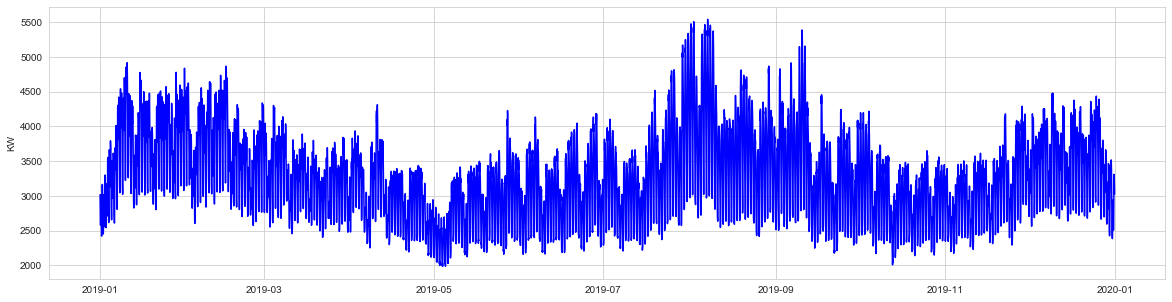

In [614]:
plt.figure(figsize=(20,5))
sns.lineplot(x=df.index, y="KW",data=df,c='b')

In [210]:
# Many people in Tokyo area are on vacation on18th weeks ( Last week of April) same trend in 52weeks  

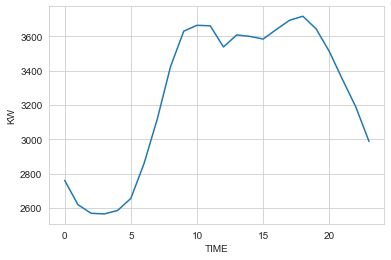

In [211]:
t_df=df.groupby('TIME').mean()
sns.lineplot(x=t_df.index, y=t_df.KW,data=df)
# the electricity has been consumed during the daytime as expected 

In [212]:
df_hour=df.resample('8H').mean()
df_hour.rename(columns={'TIME':'Morning-Day-Night'},inplace=True)

In [213]:
daily_ana=df_hour.pivot_table(values='KW', index="MONTH", columns='Morning-Day-Night',aggfunc='mean')

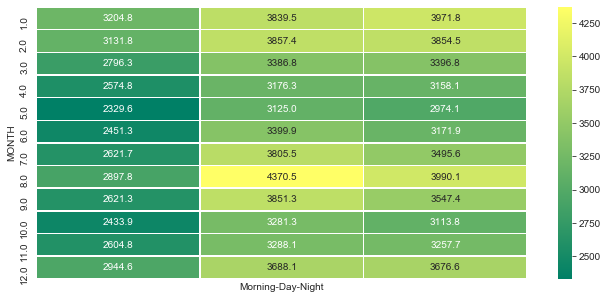

In [615]:
f, ax = plt.subplots(figsize=(11, 5))
sns.heatmap(daily_ana, annot=True,fmt='1.1f',linewidths=.5,ax=ax,cmap='summer',xticklabels=False,)
# during summer vacation, people tends to use more electricity in daytime. By contrast, less energy consumed in the morning annually) 

In [215]:
weekly_grouped=df.groupby('Mon~Sun')['KW'].mean()

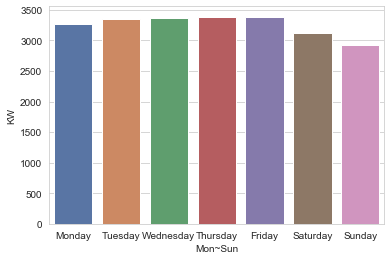

In [216]:
sns.barplot(x=weekly_grouped.index, y=weekly_grouped, palette="deep"
            ,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

# if business is off, it has more impact on the electricity impact than individual family consumption

# Convert the data

In [217]:
main=df.copy()

In [218]:
main['DATE']=main.index.date

In [219]:
main.index=main['DATE']

In [220]:
w_df.index= pd.to_datetime(w_df.index, format='%Y-%m-%d %H:%M:%S')
w_df.columns

Index(['W _day', 'W_night', 'Ave Temp', 'Max Temp', 'Time for Max Temp',
       'Min Temp', 'Time for Min Temp', 'Rain Amt_mm', 'Daylight _Hrs',
       'Snow Amt_cm', 'Mean Wind Speed', 'Level_Humidity_hPa',
       'M_Cloudiness_level'],
      dtype='object')

In [221]:
main['AVETEMP']=w_df['Ave Temp']
main['MAXTEMP']=w_df['Max Temp']
main['MINTEMP']=w_df['Min Temp']
main['Daylight_Hrs']=w_df['Daylight _Hrs']
main['Wind']=w_df['Mean Wind Speed']
main['Humidity']=w_df['Level_Humidity_hPa']
main['Cloudiness']=w_df['M_Cloudiness_level']

In [222]:
main.head()
main=main.drop('DATE',axis=1)

In [223]:
main.head()

,TIME,KW,MONTH,WEEK,Mon~Sun,AVETEMP,MAXTEMP,MINTEMP,Daylight_Hrs,Wind,Humidity,Cloudiness
DATE,,,,,,,,,,,,
2019-01-01,0,3017,1,1,Tuesday,5.3,10.7,0.9,8.9,2.3,4.7,0.5
2019-01-01,1,2849,1,1,Tuesday,5.3,10.7,0.9,8.9,2.3,4.7,0.5
2019-01-01,2,2730,1,1,Tuesday,5.3,10.7,0.9,8.9,2.3,4.7,0.5
2019-01-01,3,2636,1,1,Tuesday,5.3,10.7,0.9,8.9,2.3,4.7,0.5
2019-01-01,4,2579,1,1,Tuesday,5.3,10.7,0.9,8.9,2.3,4.7,0.5


In [224]:
main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 2019-01-01 to 2019-12-31
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TIME          8760 non-null   int64  
 1   KW            8760 non-null   int64  
 2   MONTH         8760 non-null   int64  
 3   WEEK          8760 non-null   int64  
 4   Mon~Sun       8760 non-null   object 
 5   AVETEMP       8760 non-null   float64
 6   MAXTEMP       8760 non-null   float64
 7   MINTEMP       8760 non-null   float64
 8   Daylight_Hrs  8760 non-null   float64
 9   Wind          8760 non-null   float64
 10  Humidity      8760 non-null   float64
 11  Cloudiness    8760 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 889.7+ KB


In [225]:
main.isnull().any()

TIME            False
KW              False
MONTH           False
WEEK            False
Mon~Sun         False
AVETEMP         False
MAXTEMP         False
MINTEMP         False
Daylight_Hrs    False
Wind            False
Humidity        False
Cloudiness      False
dtype: bool

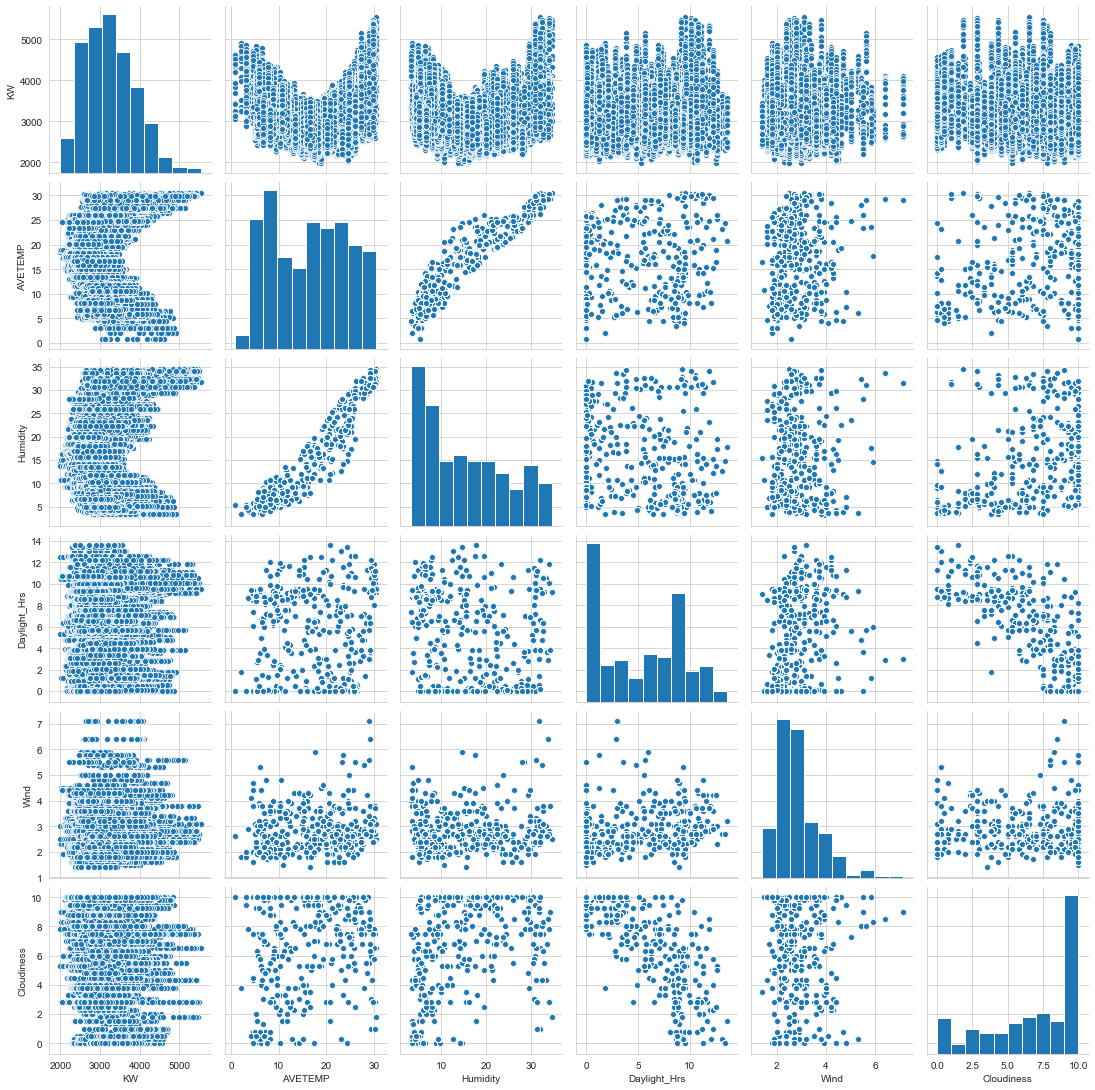

In [226]:
sns.pairplot(main, palette="coolwarm",vars=['KW', 'AVETEMP','Humidity','Daylight_Hrs','Wind','Cloudiness'],)

# There is definitely relationship between KW and Temperature/ Humidity /Wind

Text(0, 0.5, 'Temp')

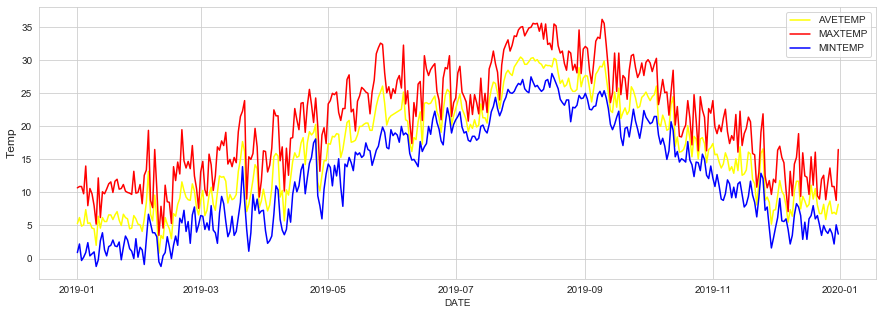

In [227]:
main['AVETEMP'].plot(figsize=(15,5),color ='yellow')
main['MAXTEMP'].plot(figsize=(15,5),color='red')
main['MINTEMP'].plot(figsize=(15,5),color='blue')

plt.legend()
plt.ylabel('Temp',size=12)

Text(0, 0.5, 'Humidity')

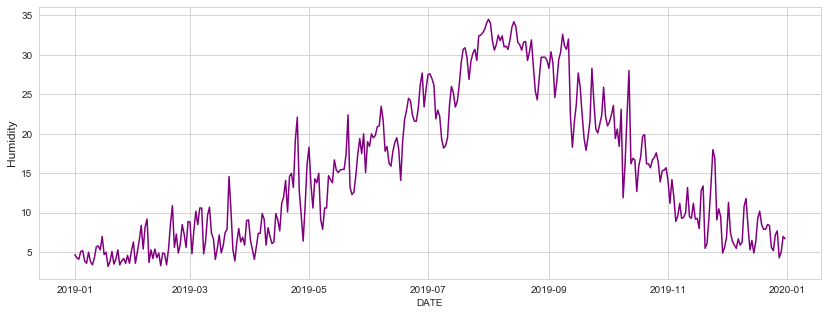

In [228]:
main['Humidity'].plot(figsize=(14,5),color='purple')
plt.ylabel('Humidity',size=12)

In [229]:
main['Wind']=main['Wind'].round()

# Round up Wind data to make it simple 

Text(0, 0.5, 'Hr of Day light')

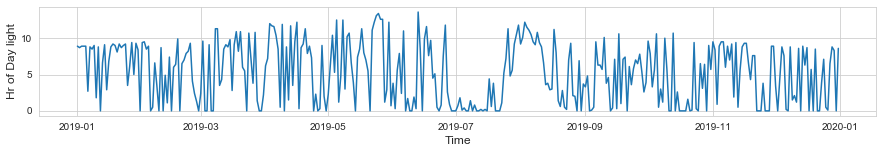

In [230]:
main['Daylight_Hrs'].plot(figsize=(15,2))
plt.xlabel('Time', size=12)
plt.ylabel('Hr of Day light',size=12)

# realize this Hr of Day light data is not acurate 

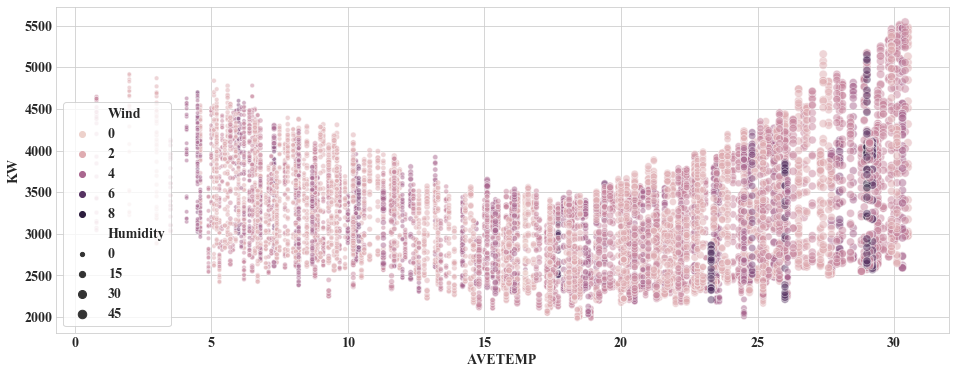

In [559]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=main,x='AVETEMP',y='KW',hue='Wind',alpha=0.5,size='Humidity',cmap='r')
plt.grid(True)
plt.legend

-The techniques you used to model the data and test it's validity
  Linear Regression / SVM / Decision Tree / Arima Model ( extra ) 

# Modeling

1. Linear Regression 
2. Suport Vector Regression 
3. Decision Tree- Regression ( Randome Forest / Boosting ) 
4. Arima Model 

In [232]:
model_df=main.copy()

In [233]:
model_df=model_df.rename(columns={'Mon~Sun':'WEEKDAY'})

In [234]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 2019-01-01 to 2019-12-31
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TIME          8760 non-null   int64  
 1   KW            8760 non-null   int64  
 2   MONTH         8760 non-null   int64  
 3   WEEK          8760 non-null   int64  
 4   WEEKDAY       8760 non-null   object 
 5   AVETEMP       8760 non-null   float64
 6   MAXTEMP       8760 non-null   float64
 7   MINTEMP       8760 non-null   float64
 8   Daylight_Hrs  8760 non-null   float64
 9   Wind          8760 non-null   float64
 10  Humidity      8760 non-null   float64
 11  Cloudiness    8760 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 889.7+ KB


In [235]:
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score
import statsmodels.formula.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.arima_model import ARIMA # Arima model 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf      # Autoregression 
from statsmodels.tsa.stattools import pacf    # Partical Autoregression 
from statsmodels.tsa.seasonal import seasonal_decompose # visualize Observation / Trend / Seanality and Residual
from statsmodels.tsa.stattools import adfuller   # Stationary or Non-Statinary test

In [236]:
model_df.head()

,TIME,KW,MONTH,WEEK,WEEKDAY,AVETEMP,MAXTEMP,MINTEMP,Daylight_Hrs,Wind,Humidity,Cloudiness
DATE,,,,,,,,,,,,
2019-01-01,0,3017,1,1,Tuesday,5.3,10.7,0.9,8.9,2.0,4.7,0.5
2019-01-01,1,2849,1,1,Tuesday,5.3,10.7,0.9,8.9,2.0,4.7,0.5
2019-01-01,2,2730,1,1,Tuesday,5.3,10.7,0.9,8.9,2.0,4.7,0.5
2019-01-01,3,2636,1,1,Tuesday,5.3,10.7,0.9,8.9,2.0,4.7,0.5
2019-01-01,4,2579,1,1,Tuesday,5.3,10.7,0.9,8.9,2.0,4.7,0.5


# Linear Regression

In [237]:
X1= model_df[['TIME','WEEK','MONTH','AVETEMP','Humidity','Wind']]

In [327]:
#X1_train, X1_test, Y_train, Y_test = train_test_split(X1,model_df.KW)
kf4 = model_selection.KFold(n_splits=4,shuffle=True)
set1,set2,set3,set4 = kf4.split(model_df)

In [328]:
df_train1 = model_df.iloc[set1[0],:]
df_test1 = model_df.iloc[set1[1],:]

df_train2 = model_df.iloc[set2[0],:]
df_test2 = model_df.iloc[set2[1],:]

df_train3 = model_df.iloc[set3[0],:]
df_test3 = model_df.iloc[set3[1],:]

df_train4 = model_df.iloc[set4[0],:]
df_test4 = model_df.iloc[set4[1],:]

In [329]:
LR= LinearRegression()

In [516]:
X1= df_train4[['TIME','WEEK','MONTH','AVETEMP','Humidity','Wind']]
Y1=df_train4['KW']
X2= df_test4[['TIME','WEEK','MONTH','AVETEMP','Humidity','Wind']]
Y2=df_test4['KW']

In [517]:
LR.fit(X1,Y1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [518]:
coeff_df = DataFrame(model_df.columns)
coeff_df.columns = ['Features']

coeff_df["Coefficient Estimate"] = pd.Series(LR.coef_)

coeff_df

,Features,Coefficient Estimate
0,TIME,40.501917
1,KW,9.111699
2,MONTH,-54.133153
3,WEEK,-70.830123
4,WEEKDAY,61.484168
5,AVETEMP,34.909134
6,MAXTEMP,NaN
7,MINTEMP,NaN
8,Daylight_Hrs,NaN
9,Wind,NaN


In [519]:
pred_train = LR.predict(X1)
pred_test = LR.predict(X2)

In [520]:
print('RMSE with X Train ＝{:0.2f}'.format((np.mean((Y1- pred_train) ** 2))**0.5)) 
print('RMSE with X Test＝{:0.2f}'.format((np.mean((Y2 - pred_test) ** 2))**0.5))

RMSE with X Train ＝538.83
RMSE with X Test＝538.77


Text(0.5, 1.0, 'Residual Plots')

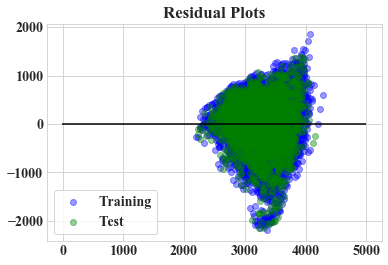

In [521]:
train = plt.scatter(pred_train,(pred_train-Y1),c='b',alpha=0.4)
test = plt.scatter(pred_test,(pred_test-Y2),c='g',alpha=0.4)
plt.hlines(y=0,xmin=-10,xmax=5000)
plt.legend((train,test),('Training','Test'),loc='lower left')
plt.title('Residual Plots')

In [244]:
stats_LR=model_df

In [245]:
model_df.head()

,TIME,KW,MONTH,WEEK,WEEKDAY,AVETEMP,MAXTEMP,MINTEMP,Daylight_Hrs,Wind,Humidity,Cloudiness
DATE,,,,,,,,,,,,
2019-01-01,0,3017,1,1,Tuesday,5.3,10.7,0.9,8.9,2.0,4.7,0.5
2019-01-01,1,2849,1,1,Tuesday,5.3,10.7,0.9,8.9,2.0,4.7,0.5
2019-01-01,2,2730,1,1,Tuesday,5.3,10.7,0.9,8.9,2.0,4.7,0.5
2019-01-01,3,2636,1,1,Tuesday,5.3,10.7,0.9,8.9,2.0,4.7,0.5
2019-01-01,4,2579,1,1,Tuesday,5.3,10.7,0.9,8.9,2.0,4.7,0.5


In [523]:
import statsmodels.formula.api as smf 

In [628]:
model = smf.ols(data =model_df, formula = "KW~TIME+AVETEMP")  
result = model.fit()

In [629]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     KW   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     1034.
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        20:40:30   Log-Likelihood:                -68116.
No. Observations:                8760   AIC:                         1.362e+05
Df Residuals:                    8757   BIC:                         1.363e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2867.9932     17.663    162.371      0.000    2833.369    2902.617
TIME          40.1517      0.890     45.122      0.000      38.407      41.896
AVETEMP       -4.4117      0.789     -5.592      0.000      -5.958      -2.865
==============================================================================
Omnibus:                      777.377   Durbin-Watson:                   0.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1039.464
Skew:                           0.749   Prob(JB):                    1.92e-226
Kurtosis:                       3.778   Cond. No.                         61.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

            AVETEMP  linear_prediction  quadratic_prediction  \
DATE                                                           
2019-01-01      5.3        3306.355739           3740.883533   
2019-01-01      5.3        3306.355739           3740.883533   
2019-01-01      5.3        3306.355739           3740.883533   
2019-01-01      5.3        3306.355739           3740.883533   
2019-01-01      5.3        3306.355739           3740.883533   

            quintic_prediction  
DATE                            
2019-01-01          3695.01184  
2019-01-01          3695.01184  
2019-01-01          3695.01184  
2019-01-01          3695.01184  
2019-01-01          3695.01184  


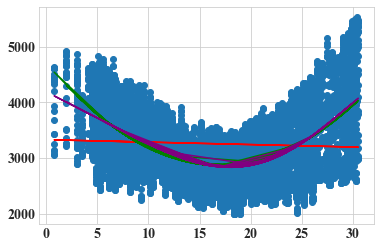

In [541]:
poly1 = smf.ols("KW ~ AVETEMP", data = model_df).fit()
poly2 = smf.ols("KW ~ AVETEMP + np.power(AVETEMP, 2)", data = model_df).fit()
poly5 = smf.ols("KW ~ AVETEMP + np.power(AVETEMP, 2) + np.power(AVETEMP, 3) + np.power(AVETEMP, 4) + np.power(AVETEMP, 5)", data = model_df).fit()

temp_df = pd.DataFrame(model_df['AVETEMP'])
#temp_df = pd.DataFrame({"AVETEMP": np.arange(0, 35, 0.1)})
temp_df['linear_prediction'] = poly1.predict(temp_df)
temp_df['quadratic_prediction'] = poly2.predict(temp_df)
temp_df['quintic_prediction'] = poly5.predict(temp_df)
print(temp_df.head())
plt.scatter(model_df['AVETEMP'], model_df['KW'])
plt.plot(temp_df['AVETEMP'], temp_df['linear_prediction'], color = 'red')
plt.plot(temp_df['AVETEMP'], temp_df['quadratic_prediction'], color='green')
plt.plot(temp_df['AVETEMP'], temp_df['quintic_prediction'], color = 'purple')

Adding polynominal features to curve the line to fit the data better . 

In [542]:
result2=poly2
result3=poly5

In [543]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     KW   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     1797.
Date:                Tue, 23 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:46:52   Log-Likelihood:                -67538.
No. Observations:                8760   AIC:                         1.351e+05
Df Residuals:                    8757   BIC:                         1.351e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4716.3213     26.871    175.516      0.000    4663.648    4768.995
AVETEMP               -218.0612      3.657    -59.624      0.000    -225.230    -210.892
np.power(AVETEMP, 2)     6.4182      0.108     59.647      0.000       6.207       6.629
==============================================================================
Omnibus:                      435.976   Durbin-Watson:                   0.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.013
Skew:                          -0.006   Prob(JB):                     2.70e-38
Kurtosis:                       2.312   Cond. No.                     2.00e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [544]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     KW   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     745.4
Date:                Tue, 23 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:46:53   Log-Likelihood:                -67490.
No. Observations:                8760   AIC:                         1.350e+05
Df Residuals:                    8754   BIC:                         1.350e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4193.7471    115.204     36.403      0.000    3967.921    4419.573
AVETEMP                -94.5893     50.898     -1.858      0.063    -194.362       5.183
np.power(AVETEMP, 2)     1.1110      8.239      0.135      0.893     -15.039      17.261
np.power(AVETEMP, 3)    -0.3080      0.600     -0.513      0.608      -1.484       0.868
np.power(AVETEMP, 4)     0.0239      0.020      1.201      0.230      -0.015       0.063
np.power(AVETEMP, 5)    -0.0004      0.000     -1.582      0.114      -0.001    9.24e-05
==============================================================================
Omnibus:                      509.296   Durbin-Watson:                   0.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.531
Skew:                          -0.027   Prob(JB):                     4.23e-42
Kurtosis:                       2.280   Cond. No.                     1.75e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

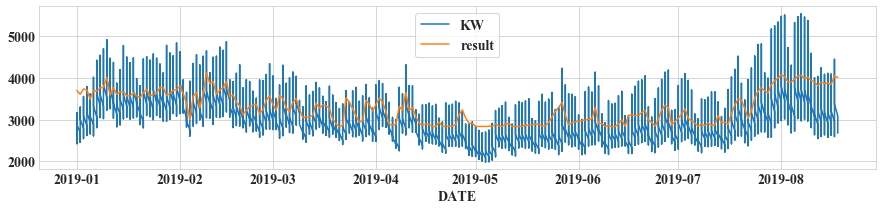

In [554]:
df_result = pd.DataFrame({"KW":model_df['KW'],"result":temp_df['quintic_prediction']})
df_result[:5500].plot(figsize=(15, 3))

# Support Vector Machine (SVM)

In [599]:
from IPython.display import Image

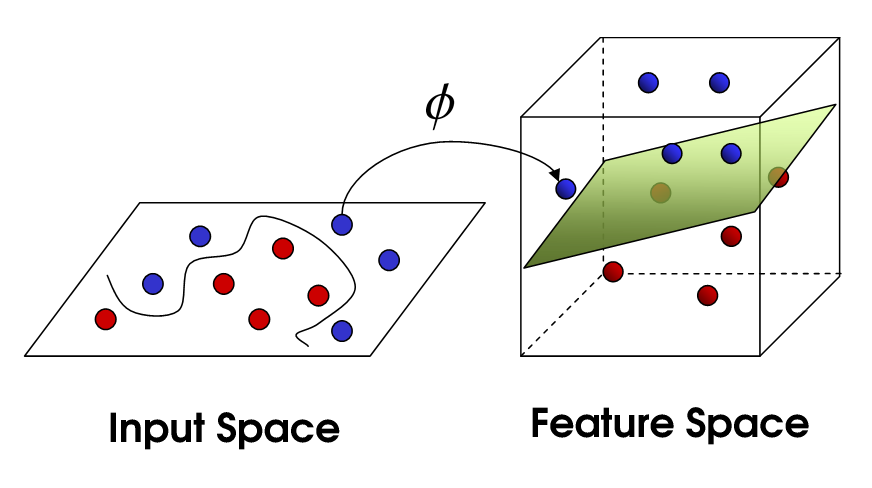

In [249]:
url='http://i.imgur.com/WuxyO.png'
Image(url)

In [252]:
model_svm = svm.SVR(kernel='rbf')

In [366]:
kf_4 = model_selection.KFold(n_splits=4,shuffle=True)
set1,set2,set3,set4 = kf_4.split(model_df)

In [367]:
train1_df = model_df.iloc[set1[0],:]
test1_df = model_df.iloc[set1[1],:]

train2_df = model_df.iloc[set2[0],:]
test2_df= model_df.iloc[set2[1],:]

train3_df = model_df.iloc[set3[0],:]
test3_df = model_df.iloc[set3[1],:]

train4_df = model_df.iloc[set4[0],:]
test4_df = model_df.iloc[set4[1],:]

In [501]:
X_1=train４_df[['TIME','MONTH','AVETEMP']]
Y_1=train3_df['KW']
X_2=test3_df[['TIME','MONTH','AVETEMP']]
Y_2=test3_df['KW']

In [502]:
model_svm.fit(X_1, Y_1)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [503]:
model_svm.score(X_1,Y_1)

0.40751188686651324

In [504]:
model_svm.score(X_2,Y_2)

0.40759027317157426

# DT-Random Forest / Boosting

In [624]:
X_cols= ['TIME','MONTH','WEEK','AVETEMP','Humidity','Wind']
y_cols=['KW']

In [625]:
X= model_df[X_cols].values.astype('float')
y = model_df[y_cols].values.astype('int').flatten()

In [626]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [263]:
model2 = RandomForestRegressor()
model2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [264]:
model2.score(X_test,y_test)

0.9652404100398317

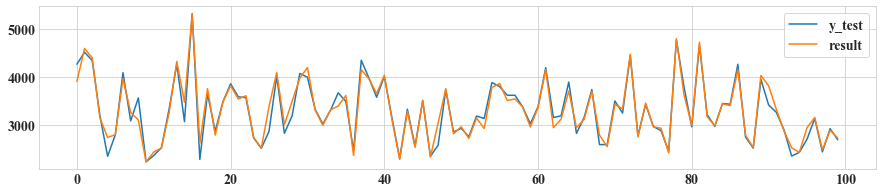

In [265]:
result = model2.predict(X_test)
df_result = pd.DataFrame({"y_test":y_test,"result":result})
df_result[:100].plot(figsize=(15, 3))

In [266]:
kf5 = model_selection.KFold(n_splits=5,shuffle=True)
list=[]
for train, test in kf5.split(X,y):
    print(train,test)
    X_train=X[train]
    y_train=y[train]
    X_test=X[test]
    y_test=y[test]
    model2.fit(X_train,y_train)
    prd= model2.predict(X_test)
    print(model2.score(X_test,y_test))
    list.append(model2.score(X_test,y_test))

[   0    1    2 ... 8757 8758 8759] [  13   15   16 ... 8735 8738 8747]
0.9633408143261059
[   0    1    3 ... 8757 8758 8759] [   2    5    9 ... 8740 8742 8754]
0.9709260472757264
[   1    2    3 ... 8753 8754 8759] [   0    4    7 ... 8756 8757 8758]
0.964815872181395
[   0    1    2 ... 8757 8758 8759] [   3    8   17 ... 8743 8749 8753]
0.9707424019356133
[   0    2    3 ... 8756 8757 8758] [   1    6   10 ... 8746 8752 8759]
0.9739599957216575


In [267]:
np.mean(list)

0.9687570262880996

In [627]:
model3= GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=8, random_state=0)
model3.fit(X_train, y_train)
predicted= model3.predict(X_test)

In [269]:
model3.score(X_test,y_test)

0.9604392592572857

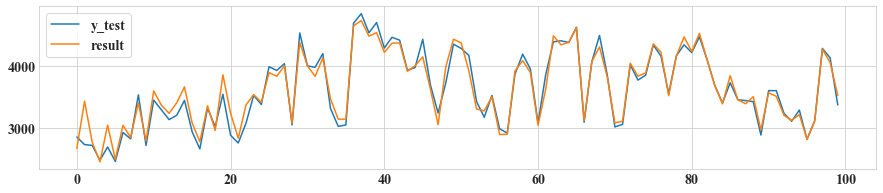

In [270]:
df_result = pd.DataFrame({"y_test":y_test,"result":predicted})
df_result[:100].plot(figsize=(15, 3))

In [271]:
kf5 = model_selection.KFold(n_splits=5,shuffle=True)
list=[]
for train, test in kf5.split(X,y):
    print(train,test)
    X_train=X[train]
    y_train=y[train]
    X_test=X[test]
    y_test=y[test]
    model3.fit(X_train,y_train)
    prd= model3.predict(X_test)
    print(model3.score(X_test,y_test))
    list.append(model3.score(X_test,y_test))

[   0    1    2 ... 8754 8755 8759] [   3    6    8 ... 8756 8757 8758]
0.9658012633896139
[   0    1    3 ... 8757 8758 8759] [   2   10   14 ... 8740 8748 8749]
0.9639766431078317
[   2    3    4 ... 8757 8758 8759] [   0    1    5 ... 8746 8750 8755]
0.9572919859613688
[   0    1    2 ... 8756 8757 8758] [  12   13   15 ... 8747 8751 8759]
0.9693886136323407
[   0    1    2 ... 8757 8758 8759] [   4   19   25 ... 8723 8727 8754]
0.9691862761049583


In [272]:
np.mean(list) # Final score after 5K 

0.9651289564392227

# Arima Model 
Auto Regressie Integrated Moving Average is a generalization of an autoregressive moving average model 
This model is fitted to time series data for better understanding and forecast future points in the series.

There are 2 types of models in Arima, Non-seasonal and Seasonal model.and I will use Seasonal Model in this data. ( more complicted) 

Keywords: 
 1. Stationary or Non-Stationary 
     -> data has constant mean and variance over the period. 
 2. Autoregression / Integrated / Moving average 

In [273]:
df_kw=pd.read_excel('Electricity_2019.xlsx',sheet_name='Sheet1',index_col = 0,parse_dates=True,skiprows=2)

In [274]:
df_kw.head()

,TIME,kW:10000
DATE,,
2019-01-01,00:00:00,3017
2019-01-01,01:00:00,2849
2019-01-01,02:00:00,2730
2019-01-01,03:00:00,2636
2019-01-01,04:00:00,2579


In [275]:
df_kw.drop('TIME',axis=1,inplace=True)

In [276]:
df_kw.columns = ['KW']

In [277]:
df_kw=df_kw.groupby(df_kw.index)['KW'].mean()

In [278]:
df_kw=DataFrame(df_kw)

In [279]:
df_kw.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='DATE', length=365, freq=None)

In [280]:
df_kw.head()

,KW
DATE,
2019-01-01,2804.708333
2019-01-02,2828.375000
2019-01-03,2981.750000
2019-01-04,3247.833333
2019-01-05,3148.958333


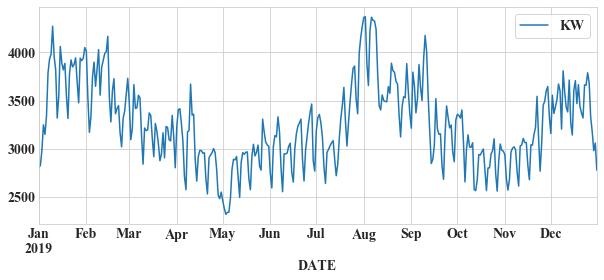

In [281]:
df_kw.plot(figsize=(10,4))

In [282]:
time_series=df_kw['KW']

In [283]:
type(time_series)

pandas.core.series.Series

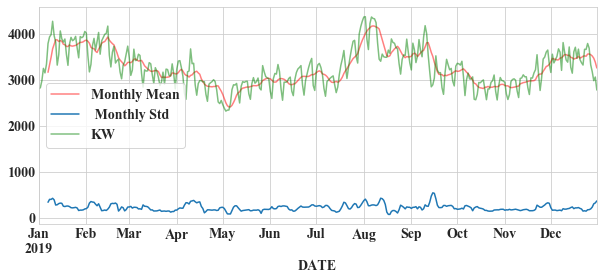

In [284]:
time_series.rolling(7).mean().plot(label='Monthly Mean',alpha=0.5,color='r')
time_series.rolling(7).std().plot(label =" Monthly Std")
time_series.plot(figsize = (10,4),color='green',alpha=0.5)
plt.legend(loc = 'best')
# it looks pretty flat data set we can work on it properly

In [285]:
decomp=seasonal_decompose(df_kw,freq=7)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


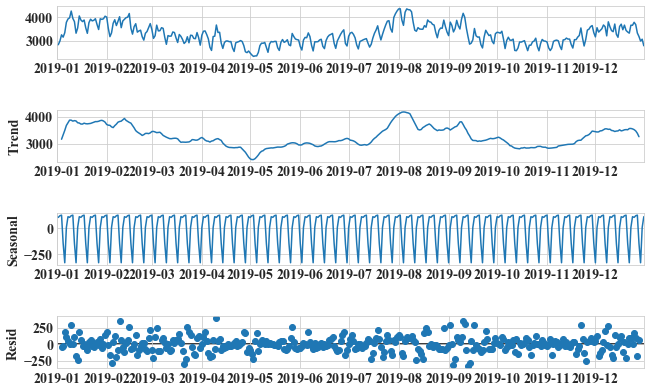

In [286]:
zz=decomp.plot()
zz.set_size_inches(10,6)

In [287]:
def adf_check(time_series):
    result=adfuller(time_series)
    print('Augumented Dickey Fuller Test ')
    labels=['ADF Test Statistic','p-value','# of Lags','# of Observation used']
    
    for value,label in zip(result,labels):
        print(label + "  "+ str(value))
    if result[1]  <= 0.05:
        print('Reject Null Hypothesis')
        print('Data is Stationary')
    else:
        print('Cannot reject Null Hypothesis')
        print('Data is Non-Stationary')

In [288]:
adf_check (df_kw['KW'])

Augumented Dickey Fuller Test 
ADF Test Statistic  -2.5999414377058097
p-value  0.09300937167794376
# of Lags  14
# of Observation used  350
Cannot reject Null Hypothesis
Data is Non-Stationary


In [289]:
plt.close()

df_kw['first_diff'] = df_kw['KW'] - df_kw['KW'].shift(1)  
adf_check(df_kw.first_diff.dropna(inplace=False))

Augumented Dickey Fuller Test 
ADF Test Statistic  -5.546438640715902
p-value  1.65679001112231e-06
# of Lags  13
# of Observation used  350
Reject Null Hypothesis
Data is Stationary


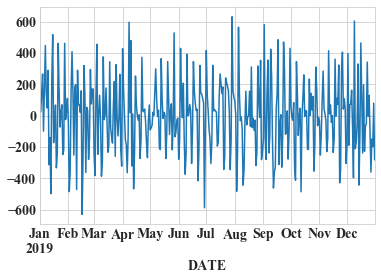

In [290]:
df_kw['first_diff'].plot()

In [291]:
plt.close()

df_kw['seasonal_diff'] = df_kw['KW'] - df_kw['KW'].shift(7)  
adf_check(df_kw.seasonal_diff.dropna(inplace=False))

Augumented Dickey Fuller Test 
ADF Test Statistic  -3.703921300060022
p-value  0.004058334413734093
# of Lags  14
# of Observation used  343
Reject Null Hypothesis
Data is Stationary


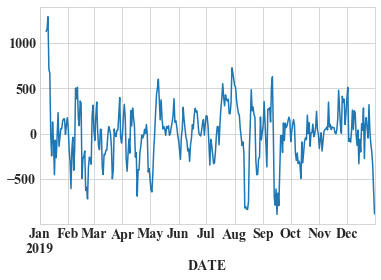

In [292]:
df_kw['seasonal_diff'].plot()

In [293]:
plt.close()

df_kw['first_seasonal_diff'] = df_kw['first_diff'] - df_kw['first_diff'].shift(7)  
adf_check(df_kw.first_seasonal_diff.dropna(inplace=False))

Augumented Dickey Fuller Test 
ADF Test Statistic  -9.21024728259059
p-value  1.8962785236071375e-15
# of Lags  13
# of Observation used  343
Reject Null Hypothesis
Data is Stationary


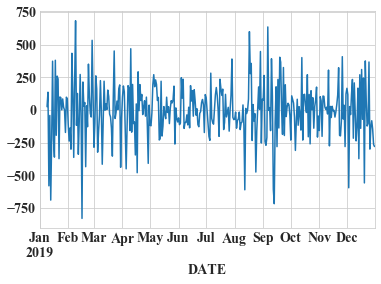

In [294]:
df_kw['first_seasonal_diff'].plot()

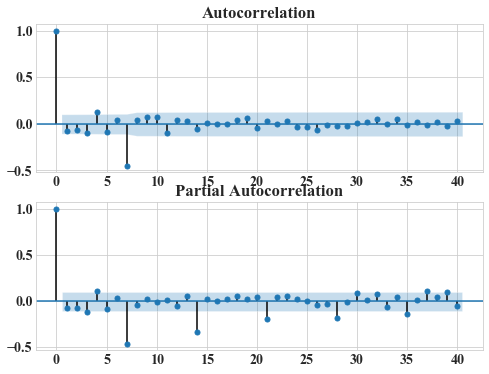

In [295]:
plt.close()

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_kw['first_seasonal_diff'].dropna(), lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_kw['first_seasonal_diff'].dropna(), lags=40, ax=ax2) # sudden drop off 

# We can see if any periodicity exist in the data. but still need to learn further to understand correctly from both graph to set the parameter.

In [296]:
diff = df_kw['first_seasonal_diff'].diff()
diff = df_kw['first_seasonal_diff'].dropna()

In [297]:
import statsmodels.api as sm

In [527]:
params = sm.tsa.arma_order_select_ic(diff, ic='aic', trend='nc')
print(params)

# 4 = Autoregression (p)
#2 = Moving Average (q) 

{'aic':              0            1            2
0          NaN  4845.057554  4845.124293
1  4845.424693  4817.564196  4818.885414
2  4845.668914  4818.786860  4814.413975
3  4843.124293  4828.220609  4808.880619
4  4840.954360  4828.496738  4808.555957, 'aic_min_order': (4, 2)}


In [528]:
mod_ar = sm.tsa.statespace.SARIMAX(df_kw['KW'], trend='n', order=(4,1,2), seasonal_order=(0,0,0,0))
result = mod_ar.fit()
print (result.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                     KW   No. Observations:                  365
Model:               SARIMAX(4, 1, 2)   Log Likelihood               -2420.106
Date:                Tue, 23 Jun 2020   AIC                           4854.212
Time:                        11:14:42   BIC                           4881.493
Sample:                    01-01-2019   HQIC                          4865.055
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9338      0.055     17.098      0.000       0.827       1.041
ar.L2         -1.0914      0.071    -15.442      0.000      -1.230      -0.953
ar.L3          0.2904      0.069      4.203      0.0

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [621]:
mod_ar_1 = sm.tsa.statespace.SARIMAX(df_kw['KW'], trend='n', order=(4,1,2), seasonal_order=(0,1,1,7))
results = mod_ar_1.fit()
print (results.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                      
Dep. Variable:                                  KW   No. Observations:                  365
Model:             SARIMAX(4, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -2314.158
Date:                             Wed, 24 Jun 2020   AIC                           4644.316
Time:                                     18:11:54   BIC                           4675.338
Sample:                                 01-01-2019   HQIC                          4656.655
                                      - 12-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9113      0.059     32.517      0.000       1.796       2.026
ar.L2         -0.9548      

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
results.resid.plot(kind='kde')

In [ ]:
#fig, ax = plt.subplots()
#ax.set(title='POWER CONSUMPTION', xlabel='Date', ylabel='Power')
#ax.plot(df_kw['KW'].loc['2019-01-01':], 'g',label="original",color="darkgrey")
#ax.plot(results.predict(start = 364, end= 450, dynamic= True),'g',label="forcast",color="green")  
#legend = ax.legend(loc='lower right')
#legend.get_frame().set_facecolor('w')

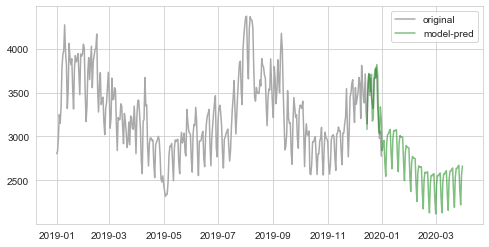

In [617]:
sarima_result = results.predict('2019-12-15', '2020-03-31') 

plt.figure(figsize=(8, 4))

plt.plot(df_kw['KW'], label="original",c='darkgrey')
plt.plot(sarima_result, c="green", label="model-pred", alpha=0.5)
plt.legend(loc='best')

# Conclusion 

　1.As I see "scatter plot" for annual electricity consumption, the model needs to be flexible to predict the future.
 I believed Linear Regression might work but it did not work at all for this data set and neither SVM. 
 ARIMA is used only considering time trend or seasonality so as a result, DT is best fit for this model and very flexible. 
   
 2.Most of Visualization was very helpful although I first thought I might only use correlation figures to see the relationship between data. 
 I believe more data or information, visualize the data using seaborn might have a good impact on anayzing process and also evaluation progress. 
